函數(For Anova)

In [108]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

from scipy.stats import bartlett, shapiro
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
def oneway_anova(df, response_col, factor_col):
    """
    Runs a one-way ANOVA on the given dataframe.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - response_col: name of the numeric response variable
    - factor_col: name of the categorical factor

    Returns:
    - ANOVA summary table (DataFrame)
    """
    
    formula = f'{response_col} ~ C({factor_col})'
    model = ols(formula, data=df).fit()
    aov_table = sms.anova_lm(model, typ=2)
    
    print("\nANOVA Table:")
    display(aov_table)
    
    return aov_table

def shapiro_wilk_test(df, response_col, factor_col, alpha=0.05):
    """
    Runs Shapiro-Wilk test for normality on each group defined by a factor column.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the response variable
    - factor_col: Name of the factor variable
    - alpha: Significance level for the Shapiro-Wilk test

    Returns:
    - A dictionary of test results per group
    """
    results = {}
    print(f"Shapiro-Wilk Test for Normality (alpha = {alpha}):\n")

    for level in df[factor_col].unique():
        group_data = df[response_col][df[factor_col] == level]
        stat, p = stats.shapiro(group_data)
        results[level] = {'Shapiro Statistic': stat, 'p-value': p}
        
        print(f"For factor = {level}")
        print(f"  Shapiro statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")
        if p > alpha:
            print("→ Likely Normal")
        else:
            print("→ Not Normal")
    
    return results

def bartlett_test(df, response_col, factor_col, alpha=0.05):
    """
    Performs Bartlett's test for equal variances across groups.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the numeric response variable
    - factor_col: Name of the categorical factor variable
    - alpha: Significance level for the test

    Returns:
    - (statistic, p-value)
    """
    groups = df[factor_col].unique()
    data_by_group = [df[response_col][df[factor_col] == group] for group in groups]

    stat, p = stats.bartlett(*data_by_group)
    print("Bartlett’s Test for Equal Variances:")
    print(f"  Test statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")

    if p > alpha:
        print("→ Equal variances assumed")
    else:
        print("→ Variances differ significantly")

    return stat, p

函數(f test, t test)

In [110]:
def f_test_variances(x1, x2, sides, alpha):
    # Convert input to NumPy arrays
    a1 = np.array(x1)
    a2 = np.array(x2)

    # Initialize results array
    result = np.full((7, 2), None, dtype=float)
    
    # Calculate basic statistics
    result[0] = [np.mean(a1), np.mean(a2)]                    # Means
    result[1] = [np.std(a1, ddof=1), np.std(a2, ddof=1)]      # Sample standard deviations
    result[2] = [a1.size, a2.size]                            # Sample sizes

    # Degrees of freedom
    dfn, dfd = a1.size - 1, a2.size - 1
    result[3] = [dfn, dfd]

    # F-statistic: ratio of sample variances
    f_stat = np.var(a1, ddof=1) / np.var(a2, ddof=1)
    result[4, 0] = f_stat

    # Critical F-values
    if sides > 1:
        result[5] = [
            stats.f.isf(alpha / 2, dfn, dfd),  # Upper critical value
            stats.f.ppf(alpha / 2, dfn, dfd)   # Lower critical value
        ]
    else:
        result[5] = [
            stats.f.isf(alpha, dfn, dfd),      # One-sided critical value
            stats.f.ppf(alpha, dfn, dfd)
        ]

    # P-value calculation
    if f_stat > 1:
        p_value = 1 - stats.f.cdf(f_stat, dfn, dfd)
    else:
        p_value = stats.f.cdf(f_stat, dfn, dfd)
    if sides > 1:
        p_value *= 2
    result[6, 0] = p_value

    # Create labeled DataFrame
    labels = ['Mean', 'Std Dev', 'Size', 'Degrees of Freedom', 'F-statistic', 'F-critical', 'p-value']
    df = pd.DataFrame(result, index=labels)

    return df

def t_test_two_means_unequal_variance(x1, x2, sides, alpha, H0_diff):
    # Convert inputs to NumPy arrays
    a1 = np.array(x1)
    a2 = np.array(x2)

    # Initialize results array
    result = np.full((8, 2), None, dtype=float)

    # Basic statistics
    mean1, mean2 = np.mean(a1), np.mean(a2)
    var1, var2 = np.var(a1, ddof=1), np.var(a2, ddof=1)
    n1, n2 = a1.size, a2.size

    result[0] = [mean1, mean2]  # Means
    result[1] = [var1, var2]    # Variances
    result[2] = [n1, n2]        # Sample sizes

    # Mean difference and its variance
    mean_diff = mean1 - mean2
    diff_var = var1 / n1 + var2 / n2

    # Hypothesized difference under H0
    result[3, 0] = H0_diff

    # Degrees of freedom (Welch-Satterthwaite equation)
    numerator = diff_var ** 2
    denominator = (var1**2 / (n1**2 * (n1 - 1))) + (var2**2 / (n2**2 * (n2 - 1)))
    df = numerator / denominator
    result[4, 0] = df

    # t-statistic
    t_stat = (mean_diff - H0_diff) / np.sqrt(diff_var)
    result[5, 0] = t_stat

    # Critical t-values
    if sides > 1:
        result[6] = [stats.t.isf(alpha / 2, df), stats.t.ppf(alpha / 2, df)]
    else:
        result[6] = [stats.t.isf(alpha, df), stats.t.ppf(alpha, df)]

    # p-value
    if t_stat > 0:
        p_value = 1 - stats.t.cdf(t_stat, df)
    else:
        p_value = stats.t.cdf(t_stat, df)
    if sides > 1:
        p_value *= 2
    result[7, 0] = p_value

    # Create labeled DataFrame
    labels = [
        'Mean', 'Variance', 'Size', 'H0 Diff',
        'Degrees of Freedom', 't-statistic', 't-critical', 'p-value'
    ]
    df = pd.DataFrame(result, index=labels)

    return df


def run_t_test_summary(df, col1, col2, usevar='pooled', alpha=0.05):
    """
    Runs a t-test using statsmodels' CompareMeans and prints a summary.

    Parameters:
    - df: DataFrame containing the columns
    - col1, col2: Column names to compare
    - usevar: 'pooled' (equal variances) or 'unequal' (Welch)
    - alpha: Significance level
    """
    group1 = sms.DescrStatsW(df[col1].values)
    group2 = sms.DescrStatsW(df[col2].values)
    t_test = sms.CompareMeans(group1, group2)
    
    return t_test.summary(usevar=usevar, alpha=alpha)



任務一


In [111]:
# ========== 開始作檢定==========

df = pd.read_csv('movie_summary.csv')

# filter data
filtered_df = df[
    (df['production_year'] > 2000) &
    (df['production_budget'] > 0) &
    (df['production_budget'] < 5000000) &
    df['sequel'].notna() &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()



# 計算總票房
filtered_df['total_box_office'] = (
    filtered_df['domestic_box_office'] + filtered_df['international_box_office']
)

filtered_df['log_total_box_office'] = np.log1p(filtered_df['total_box_office'])

print(filtered_df['log_total_box_office'].head())

424    18.707935
648    18.458747
753    18.225166
783    18.578413
784    17.646816
Name: log_total_box_office, dtype: float64


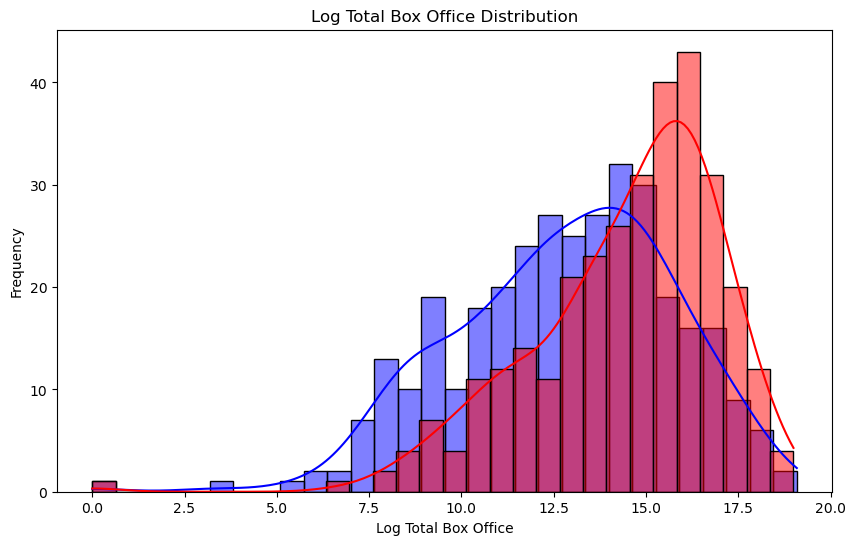

Budget Low 資料筆數：337
Budget High 資料筆數：318


In [112]:
# 新增 budget 分類
filtered_df['budget_category'] = pd.cut(filtered_df['production_budget'], bins=[10000, 1700000
, 5000000], labels=['Low', 'High'])

# 分組資料
budget_low = filtered_df[filtered_df['budget_category'] == 'Low']['log_total_box_office']
budget_high = filtered_df[filtered_df['budget_category'] == 'High']['log_total_box_office']

# Plot log_total_box_office for two groups
plt.figure(figsize=(10, 6))
sns.histplot(budget_low, bins=30, kde=True, color='blue')
sns.histplot(budget_high, bins=30, kde=True, color='red')
plt.title('Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')
plt.show()

# 寫出各個的資料筆數
print(f"Budget Low 資料筆數：{len(budget_low)}")
print(f"Budget High 資料筆數：{len(budget_high)}")

# print(filtered_df)


常態性檢定結果 (Shapiro-Wilk test)：

Budget Low 組：
樣本數：337
統計量：0.9803
p值：0.0001
結論：不符合常態分配
常態性檢定結果 (Shapiro-Wilk test)：

Budget High 組：
樣本數：318
統計量：0.9331
p值：0.0000
結論：不符合常態分配


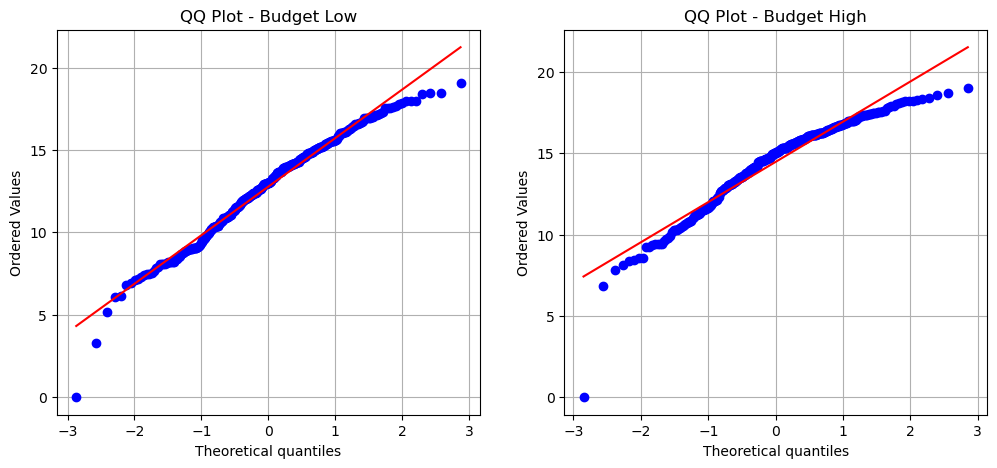

In [113]:
# 常態性檢定 (Shapiro-Wilk test)
from scipy import stats

print("常態性檢定結果 (Shapiro-Wilk test)：")
print("\nBudget Low 組：")
stat, p_value = stats.shapiro(budget_low)
print(f"樣本數：{len(budget_low)}")
print(f"統計量：{stat:.4f}")
print(f"p值：{p_value:.4f}")
print(f"結論：{'符合常態分配' if p_value > 0.05 else '不符合常態分配'}")

print("常態性檢定結果 (Shapiro-Wilk test)：")
print("\nBudget High 組：")
stat, p_value = stats.shapiro(budget_high)
print(f"樣本數：{len(budget_high)}")
print(f"統計量：{stat:.4f}")
print(f"p值：{p_value:.4f}")
print(f"結論：{'符合常態分配' if p_value > 0.05 else '不符合常態分配'}")

# 用 QQ plot 輔助
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(budget_low, dist="norm", plot=plt)
plt.title("QQ Plot - Budget Low")
plt.grid(True)
plt.subplot(1, 2, 2)
stats.probplot(budget_high, dist="norm", plot=plt)
plt.title("QQ Plot - Budget High")
plt.grid(True)
plt.show()

Sharipo跟QQ plot結論有待討論，資料不一定常態，所以變異數分析用 Levene Test


In [114]:
# 變異數同質性檢定 (Levene's test)
print("\n變異數同質性檢定 (Levene's test)：")
stat, p_value = stats.levene(budget_low, budget_high)
print(f"統計量：{stat:.4f}")
print(f"p值：{p_value:.4f}")
print(f"結論：{'變異數同質' if p_value > 0.05 else '變異數不同質'}")

# 變異數不同質所以用 kruskal-wallis test
kruskal_result = stats.kruskal(budget_low, budget_high)
print(f"\nKruskal-Wallis 統計量：{kruskal_result.statistic:.4f}")
print(f"p值：{kruskal_result.pvalue:.4f}")
print(f"結論：{'兩組平均數無顯著差異' if kruskal_result.pvalue > 0.05 else '兩組平均數有顯著差異'}")


變異數同質性檢定 (Levene's test)：
統計量：9.9417
p值：0.0017
結論：變異數不同質

Kruskal-Wallis 統計量：60.3208
p值：0.0000
結論：兩組平均數有顯著差異


以下的程式有兩種test，一種是假設兩組資料常態(welch's t test)，另一組是有一組以上資料不常態(mann-whitney u test)雖然結論都一樣

In [115]:
# 如果是兩組資料常態：welch's t test
t_result = t_test_two_means_unequal_variance(budget_low, budget_high, sides=1, alpha=0.05, H0_diff=0)

print("Welch T-Test 結果：")
print(t_result)
print(f"兩組平均數無顯著差異" if t_result.iloc[7, 0] > 0.05 else "兩組平均數有顯著差異")
print("\n")

# 如果兩組資料不常態：mann-whitney u test
mann_whitney_result = stats.mannwhitneyu(budget_low, budget_high)
print("Mann-Whitney U Test 結果：")
print(f"\n統計量：{mann_whitney_result.statistic:.4f}")
print(f"p值：{mann_whitney_result.pvalue:.4f}")
print(f"結論：{'兩組平均數無顯著差異' if mann_whitney_result.pvalue > 0.05 else '兩組平均數有顯著差異'}")


Welch T-Test 結果：
                               0           1
Mean                1.277697e+01   14.466167
Variance            8.762734e+00    6.484006
Size                3.370000e+02  318.000000
H0 Diff             0.000000e+00         NaN
Degrees of Freedom  6.475293e+02         NaN
t-statistic        -7.842584e+00         NaN
t-critical          1.647210e+00   -1.647210
p-value             9.122857e-15         NaN
兩組平均數有顯著差異


Mann-Whitney U Test 結果：

統計量：34784.5000
p值：0.0000
結論：兩組平均數有顯著差異


In [116]:
import pandas as pd
from scipy.stats import kruskal
import numpy as np

# 假設 filtered_df 已經準備好，並包含 budget_category 與 log_total_box_office
# 先去掉缺失值
df_kw = filtered_df.dropna(subset=['budget_category', 'log_total_box_office'])

# 分組取出資料
group_low  = df_kw.loc[df_kw['budget_category']=='Low',  'log_total_box_office']
group_high = df_kw.loc[df_kw['budget_category']=='High', 'log_total_box_office']

# 1. Kruskal–Wallis 檢定
H, p = kruskal(group_low, group_high)
print(f"Kruskal–Wallis H = {H:.4f}, p = {p:.4f}")

# 2. 效果量 r
#    r = sqrt(H / (N - 1)), 其中 N = group_low.size + group_high.size
N = group_low.size + group_high.size
r = np.sqrt(H / (N - 1))
print(f"效果量 r = {r:.3f}")

# 3. 各組中位數與四分位距
desc = df_kw.groupby('budget_category')['log_total_box_office'] \
            .agg(['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
desc.columns = ['median', 'Q1', 'Q3']
print("\n各組中位數與四分位距：")
print(desc)


Kruskal–Wallis H = 60.3208, p = 0.0000
效果量 r = 0.304

各組中位數與四分位距：
                    median         Q1         Q3
budget_category                                 
Low              12.993739  10.850133  14.943874
High             15.016683  13.081388  16.237046


任務二

budget_low_df的資料筆數： 337
Romantic Comedy 資料筆數： 16
Thriller/Suspense 資料筆數： 29
Comedy 資料筆數： 56
Drama 資料筆數： 127


budget_high_df的資料筆數： 318
Romantic Comedy 資料筆數： 10
Thriller/Suspense 資料筆數： 36
Comedy 資料筆數： 49
Drama 資料筆數： 128


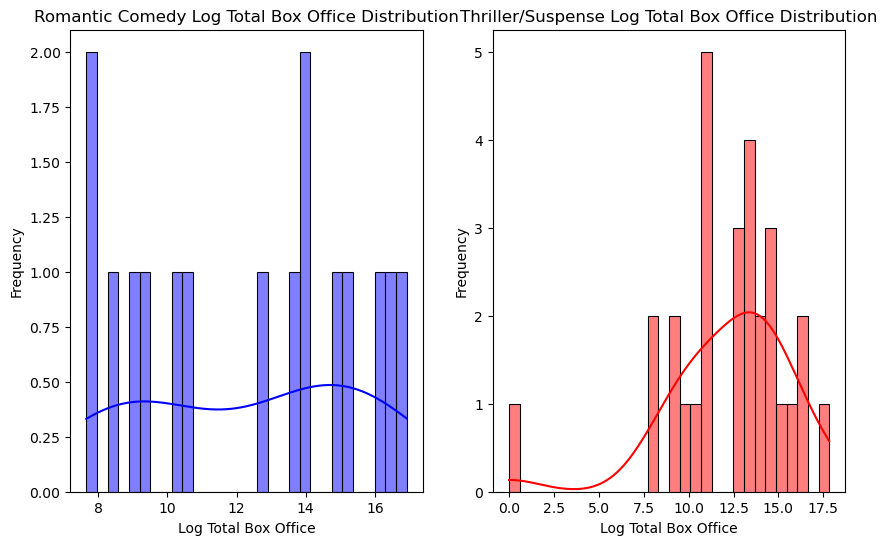

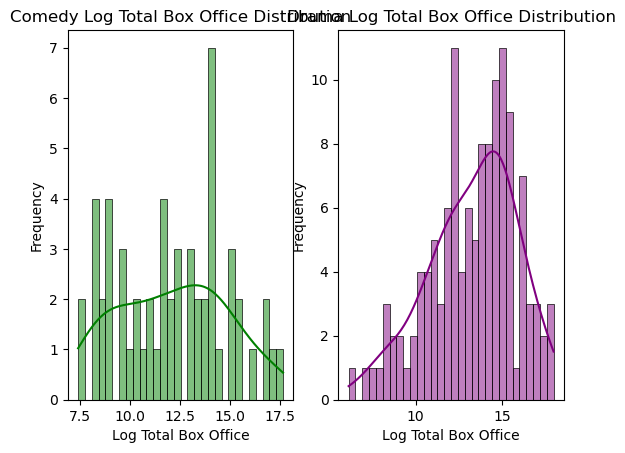

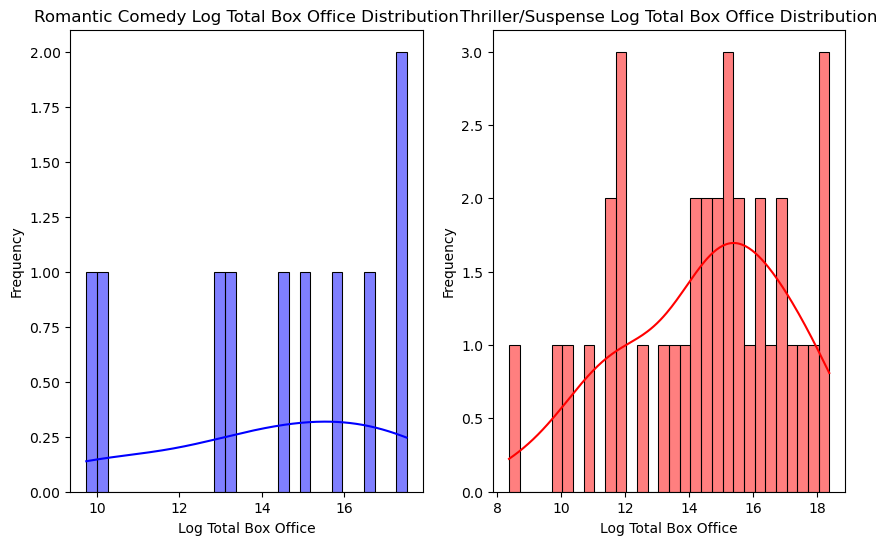

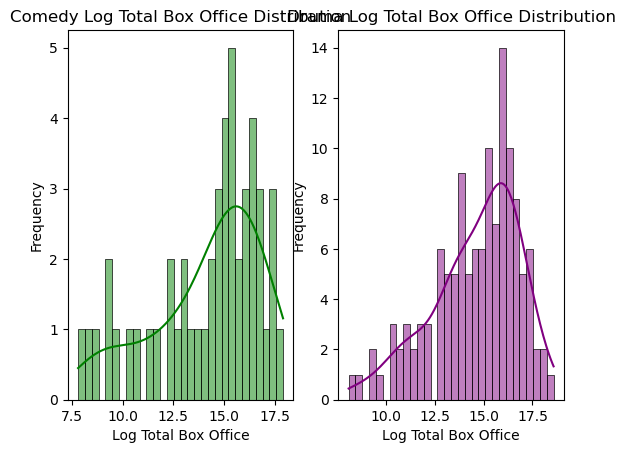

In [117]:
# 先把資料分成budget_low跟budget_high
# 這兩筆資料分別用 genre 分類(Romantic Comedy ; Thriller/Suspense ; Comedy ; Drama)

budget_low_df = filtered_df[filtered_df['budget_category'] == 'Low']
budget_high_df = filtered_df[filtered_df['budget_category'] == 'High']

low_romantic_comedy_df = budget_low_df[budget_low_df['genre'] == 'Romantic Comedy']['log_total_box_office']
low_thriller_suspense_df = budget_low_df[budget_low_df['genre'] == 'Thriller/Suspense']['log_total_box_office']
low_comedy_df = budget_low_df[budget_low_df['genre'] == 'Comedy']['log_total_box_office']
low_drama_df = budget_low_df[budget_low_df['genre'] == 'Drama']['log_total_box_office']

high_romantic_comedy_df = budget_high_df[budget_high_df['genre'] == 'Romantic Comedy']['log_total_box_office']
high_thriller_suspense_df = budget_high_df[budget_high_df['genre'] == 'Thriller/Suspense']['log_total_box_office']
high_comedy_df = budget_high_df[budget_high_df['genre'] == 'Comedy']['log_total_box_office']
high_drama_df = budget_high_df[budget_high_df['genre'] == 'Drama']['log_total_box_office']

print("budget_low_df的資料筆數：", len(budget_low_df))

print("Romantic Comedy 資料筆數：", len(low_romantic_comedy_df))
print("Thriller/Suspense 資料筆數：", len(low_thriller_suspense_df))
print("Comedy 資料筆數：", len(low_comedy_df))
print("Drama 資料筆數：", len(low_drama_df))
print("\n")

print("budget_high_df的資料筆數：", len(budget_high_df))

print("Romantic Comedy 資料筆數：", len(high_romantic_comedy_df))
print("Thriller/Suspense 資料筆數：", len(high_thriller_suspense_df))
print("Comedy 資料筆數：", len(high_comedy_df))
print("Drama 資料筆數：", len(high_drama_df))

# 畫圖，用subplot把圖畫一起
# low的圖
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(low_romantic_comedy_df, bins=30, kde=True, color='blue')
plt.title('Romantic Comedy Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(low_thriller_suspense_df, bins=30, kde=True, color='red')
plt.title('Thriller/Suspense Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')
plt.show()

plt.subplot(1, 2, 1)
sns.histplot(low_comedy_df, bins=30, kde=True, color='green')
plt.title('Comedy Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(low_drama_df, bins=30, kde=True, color='purple')
plt.title('Drama Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')
plt.show()

# high的圖
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(high_romantic_comedy_df, bins=30, kde=True, color='blue')
plt.title('Romantic Comedy Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(high_thriller_suspense_df, bins=30, kde=True, color='red')
plt.title('Thriller/Suspense Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')
plt.show()

plt.subplot(1, 2, 1)
sns.histplot(high_comedy_df, bins=30, kde=True, color='green')
plt.title('Comedy Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(high_drama_df, bins=30, kde=True, color='purple')
plt.title('Drama Log Total Box Office Distribution')
plt.xlabel('Log Total Box Office')
plt.ylabel('Frequency')
plt.show()



常態性檢定 (Shapiro-Wilk test)  
只有 Romantic Comedy 的資料筆數 < 30   
其他 Genre 畫 QQ plot  

這還沒有分budget，但應該接續任務一，分成low跟high(就跟上面一樣有先分budget再分genre
)

In [118]:

# 組合兩組資料，加上標籤
combined_df = pd.concat([budget_low_df, budget_high_df])

# 選擇目標 genre
target_genres = ['Romantic Comedy', 'Thriller/Suspense', 'Comedy', 'Drama']
combined_df = combined_df[combined_df['genre'].isin(target_genres)]

# 建立新欄位：每筆資料的 group 名稱（預算 + 類別）
combined_df['group_label'] = (
    combined_df['budget_category'].astype(str)
    + ' - '
    + combined_df['genre'].astype(str)
)


# 執行 Shapiro-Wilk 檢定
shapiro_results = shapiro_wilk_test(combined_df, 'log_total_box_office', 'group_label')

print(shapiro_results)






Shapiro-Wilk Test for Normality (alpha = 0.05):

For factor = Low - Comedy
  Shapiro statistic = 0.968868, p-value = 0.155986 → Likely Normal
For factor = Low - Drama
  Shapiro statistic = 0.975814, p-value = 0.022418 → Not Normal
For factor = Low - Thriller/Suspense
  Shapiro statistic = 0.894017, p-value = 0.007065 → Not Normal
For factor = Low - Romantic Comedy
  Shapiro statistic = 0.911909, p-value = 0.124919 → Likely Normal
For factor = High - Drama
  Shapiro statistic = 0.950716, p-value = 0.000146 → Not Normal
For factor = High - Romantic Comedy
  Shapiro statistic = 0.917806, p-value = 0.339017 → Likely Normal
For factor = High - Comedy
  Shapiro statistic = 0.906991, p-value = 0.000937 → Not Normal
For factor = High - Thriller/Suspense
  Shapiro statistic = 0.963544, p-value = 0.275827 → Likely Normal
{'Low - Comedy': {'Shapiro Statistic': 0.9688682556152344, 'p-value': 0.1559857875108719}, 'Low - Drama': {'Shapiro Statistic': 0.9758138060569763, 'p-value': 0.0224177576601505

In [119]:
# Clean genres (keep only 4 categories of interest)
target_genres = ['Romantic Comedy', 'Thriller/Suspense', 'Comedy', 'Drama']
filtered_df = filtered_df[filtered_df['genre'].isin(target_genres)]

# Fit model
model = ols('log_total_box_office ~ C(budget_category) * C(genre)', data=filtered_df).fit()

# Shapiro-Wilk test for normality of residuals
shapiro_test = shapiro(model.resid)
print("Shapiro-Wilk Test:")
print(f"Statistic = {shapiro_test.statistic:.4f}, p-value = {shapiro_test.pvalue:.4f}")
# 解釋Shapiro-Wilk檢定結果
if shapiro_test.pvalue < 0.05:
    print("\n殘差不符合常態分配 (p < 0.05)")
else:
    print("\n殘差符合常態分配 (p >= 0.05)")


# Create group combinations
groups = []
for budget in ['Low', 'High']:
    for g in target_genres:
        group = filtered_df[(filtered_df['budget_category'] == budget) & (filtered_df['genre'] == g)]
        groups.append(group['log_total_box_office'])

# Bartlett test
stat, p = bartlett(*groups)
print("\nBartlett’s Test:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")

print("\n解釋Bartlett檢定結果:")
if p < 0.05:
    print("組間變異數不相等 (p < 0.05)")
else:
    print("組間變異數相等 (p >= 0.05)")


Shapiro-Wilk Test:
Statistic = 0.9707, p-value = 0.0000

殘差不符合常態分配 (p < 0.05)

Bartlett’s Test:
Statistic = 13.8997, p-value = 0.0530

解釋Bartlett檢定結果:
組間變異數相等 (p >= 0.05)


###  Kruskal–Wallis 

In [120]:
import numpy as np
from scipy.stats import kruskal

# 1. 只保留有 genre 與 revenue 的資料
df_kw = filtered_df.dropna(subset=['genre', 'log_total_box_office']).copy()

# 2. 定義要比較的類型列表（可依實際情況調整）
genres = ['Romantic Comedy', 'Thriller/Suspense', 'Comedy', 'Drama']

# 3. 取出每一類型的票房對數數據
group_data = [ 
    df_kw.loc[df_kw['genre'] == g, 'log_total_box_office'].values 
    for g in genres
]

# 4. 執行 Kruskal–Wallis 檢定
H, p = kruskal(*group_data)
print(f"Kruskal–Wallis H = {H:.4f}, p = {p:.4f}")

# 5. 計算效果量 ε²（epsilon‐squared）
#    ε² = (H − k + 1) / (N − k)
# N = df_kw.shape[0]
# k = len(genres)
# epsilon_sq = (H - k + 1) / (N - k)
# print(f"Effect size ε² = {epsilon_sq:.3f}")

# 6. 各組中位數
medians = df_kw.groupby('genre')['log_total_box_office'].median()
print("\n各類型中位數：")
print(medians)


Kruskal–Wallis H = 6.5921, p = 0.0861

各類型中位數：
genre
Comedy               13.460640
Drama                14.173549
Romantic Comedy      13.897034
Thriller/Suspense    13.843862
Name: log_total_box_office, dtype: float64


Shapiro沒過，所以用 Scheirer–Ray–Hare test (想成是 Scheirer–Ray–Hare test)

In [121]:
from scipy.stats import rankdata

# Rank transform the dependent variable
filtered_df['ranked_box_office'] = rankdata(filtered_df['log_total_box_office'])

filtered_df.dropna(subset=['ranked_box_office','budget_category','genre'])
print(filtered_df.shape)
# Two-way ANOVA on ranks
model = ols('ranked_box_office ~ C(budget_category) + C(genre) + C(budget_category):C(genre)', data=filtered_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(filtered_df.shape)
print(anova_table)

(458, 27)
(458, 27)
                                   sum_sq     df          F        PR(>F)
C(budget_category)           7.475314e+05    1.0  47.775389  1.673402e-11
C(genre)                     1.028751e+05    3.0   2.191613  8.833602e-02
C(budget_category):C(genre)  2.720667e+04    3.0   0.579601  6.286611e-01
Residual                     6.931527e+06  443.0        NaN           NaN


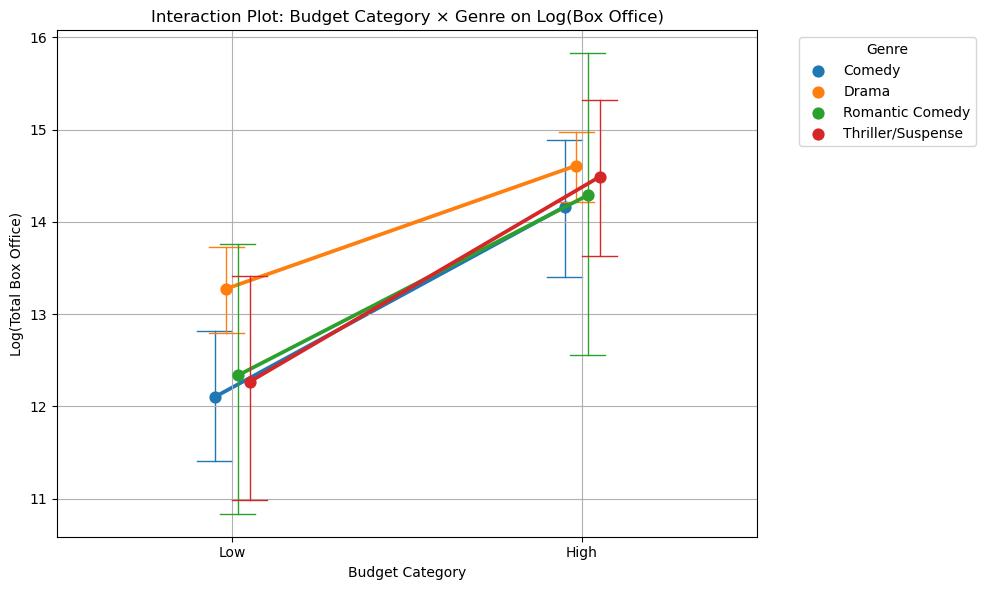

In [122]:
# Ensure budget_category and genre are categorical with proper order
filtered_df['budget_category'] = filtered_df['budget_category'].astype('category')
filtered_df['genre'] = filtered_df['genre'].astype('category')

# Interaction plot using seaborn lineplot (grouped by genre)
plt.figure(figsize=(10, 6))
sns.pointplot(
    data=filtered_df,
    x='budget_category',
    y='log_total_box_office',
    hue='genre',
    dodge=True,
    markers='o',
    capsize=.1,
    errwidth=1,
    palette='tab10'
)

plt.title('Interaction Plot: Budget Category × Genre on Log(Box Office)')
plt.ylabel('Log(Total Box Office)')
plt.xlabel('Budget Category')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


In [123]:
import numpy as np

# 先準備只含 Low/High 和票房的 DataFrame
df_cmp = filtered_df.dropna(subset=['budget_category','log_total_box_office']).copy()

# 1. 比較中位數
medians = df_cmp.groupby('budget_category')['log_total_box_office'] \
                .median()
print("各組中位數：")
print(medians)

# 2. 比較平均秩次
df_cmp['rank'] = df_cmp['log_total_box_office'].rank()
mean_ranks = df_cmp.groupby('budget_category')['rank'].mean()
print("\n各組平均秩次：")
print(mean_ranks)


各組中位數：
budget_category
Low     13.219305
High    15.007388
Name: log_total_box_office, dtype: float64

各組平均秩次：
budget_category
Low     185.679825
High    267.224215
Name: rank, dtype: float64


Task 3


敘述統計:
                     count       mean       std       min        25%  \
source_binary                                                          
Adapted              105.0  13.874889  2.481008  7.483807  12.269695   
Original Screenplay  353.0  13.485749  2.852476  0.000000  11.598259   

                           50%        75%        max  
source_binary                                         
Adapted              14.467418  15.866783  17.993668  
Original Screenplay  13.969087  15.579747  18.578413  


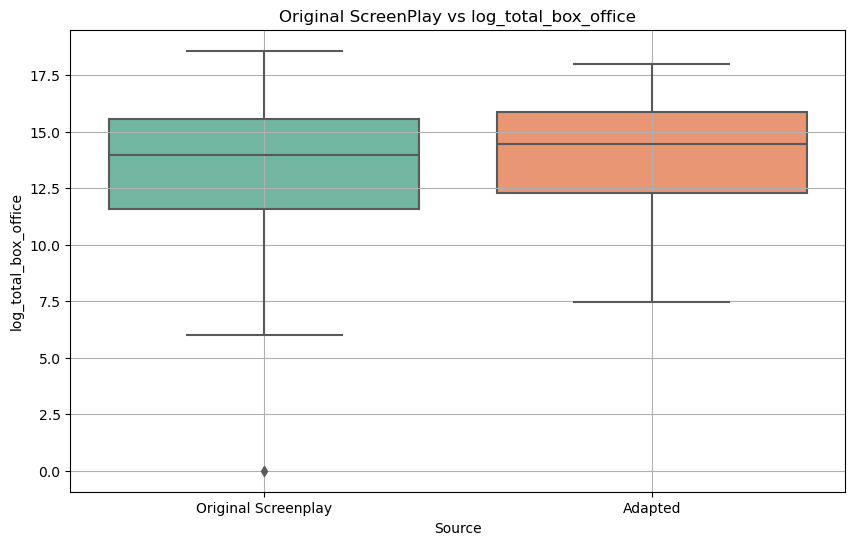

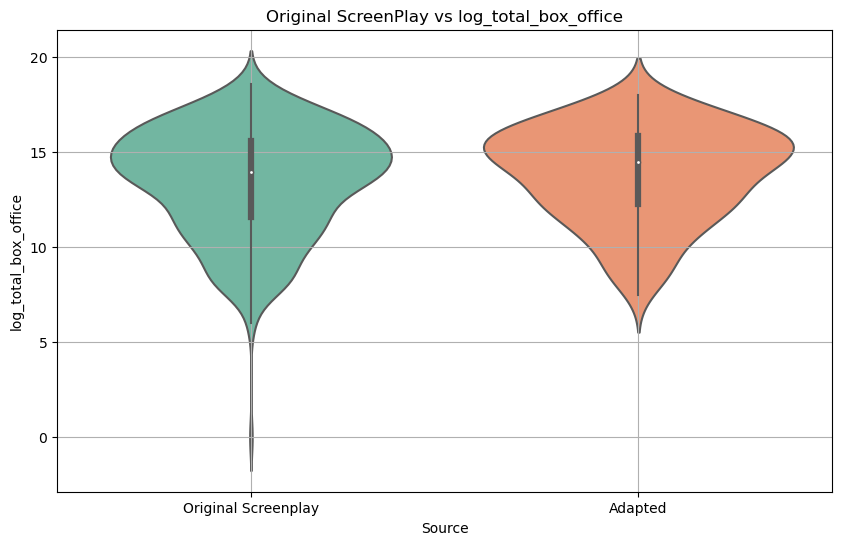

In [124]:
filtered_df['source_binary'] = filtered_df['source'].apply(lambda x: 'Original Screenplay' if x == 'Original Screenplay' else 'Adapted')

# 只分原創與否
desc_stats = filtered_df.groupby('source_binary')['log_total_box_office'].describe()
print("\n敘述統計:")
print(desc_stats)

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_df,
    x='source_binary',
    y='log_total_box_office',
    palette='Set2'
)
plt.title('Original ScreenPlay vs log_total_box_office')
plt.xlabel('Source')
plt.ylabel('log_total_box_office')
plt.grid(True)
plt.show()

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=filtered_df,
    x='source_binary',
    y='log_total_box_office',
    palette='Set2'
)
plt.title('Original ScreenPlay vs log_total_box_office')
plt.xlabel('Source')
plt.ylabel('log_total_box_office')
plt.grid(True)
plt.show()


In [125]:
# Define the filtered source and genre categories
selected_sources = ["Original Screenplay", "Based on Fiction Book/Short Story", "Based on Play"]
selected_genres = ["Thriller/Suspense", "Comedy", "Drama"]

# Filter the DataFrame
subset_df = filtered_df[
    filtered_df['source'].isin(selected_sources) &
    filtered_df['genre'].isin(selected_genres)
].copy()


# Drop NA if necessary
subset_df = subset_df.dropna(subset=['log_total_box_office'])

In [126]:
# Convert to string before concatenation
subset_df['group'] = subset_df['source'].astype(str) + " | " + subset_df['genre'].astype(str)

# Shapiro-Wilk test
for g in subset_df['group'].unique():
    data = subset_df[subset_df['group'] == g]['log_total_box_office']
    stat, p = stats.shapiro(data)
    print(f"{g} → Shapiro W={stat:.4f}, p={p:.4f} → {'Normal' if p > 0.05 else 'Not Normal'}")

Original Screenplay | Drama → Shapiro W=0.9572, p=0.0000 → Not Normal
Based on Fiction Book/Short Story | Drama → Shapiro W=0.9073, p=0.0127 → Not Normal
Original Screenplay | Thriller/Suspense → Shapiro W=0.9237, p=0.0012 → Not Normal
Original Screenplay | Comedy → Shapiro W=0.9533, p=0.0043 → Not Normal
Based on Fiction Book/Short Story | Thriller/Suspense → Shapiro W=0.9496, p=0.7134 → Normal
Based on Play | Drama → Shapiro W=1.0000, p=1.0000 → Normal
Based on Play | Comedy → Shapiro W=0.8072, p=0.0926 → Normal
Based on Fiction Book/Short Story | Comedy → Shapiro W=0.9097, p=0.2788 → Normal


In [127]:
# Create list of arrays per group
group_data = [
    subset_df[subset_df['group'] == g]['log_total_box_office'].values
    for g in subset_df['group'].unique()
]

# Bartlett’s test
stat, p = stats.bartlett(*group_data)
print(f"Bartlett’s test: Stat = {stat:.4f}, p = {p:.4f} → {'Equal Variances' if p > 0.05 else 'Unequal Variances'}")

Bartlett’s test: Stat = 9.9882, p = 0.1892 → Equal Variances


In [128]:
from scipy.stats import rankdata

# Rank transform the dependent variable
subset_df['ranked_box_office'] = rankdata(subset_df['log_total_box_office'])

# Two-way ANOVA on ranks
model = ols('ranked_box_office ~ C(source) + C(genre) + C(source):C(genre)', data=subset_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)



                          sum_sq     df         F    PR(>F)
C(source)                    NaN    2.0       NaN       NaN
C(genre)                     NaN    3.0       NaN       NaN
C(source):C(genre)  3.941813e+04    6.0  0.550258  0.648255
Residual            4.465297e+06  374.0       NaN       NaN


/Users/albert/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/albert/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1917: RuntimeWarning: invalid value encountered in divide
  F /= J
/Users/albert/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/albert/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 3
  warnings.warn('covariance of constraints does not have full '


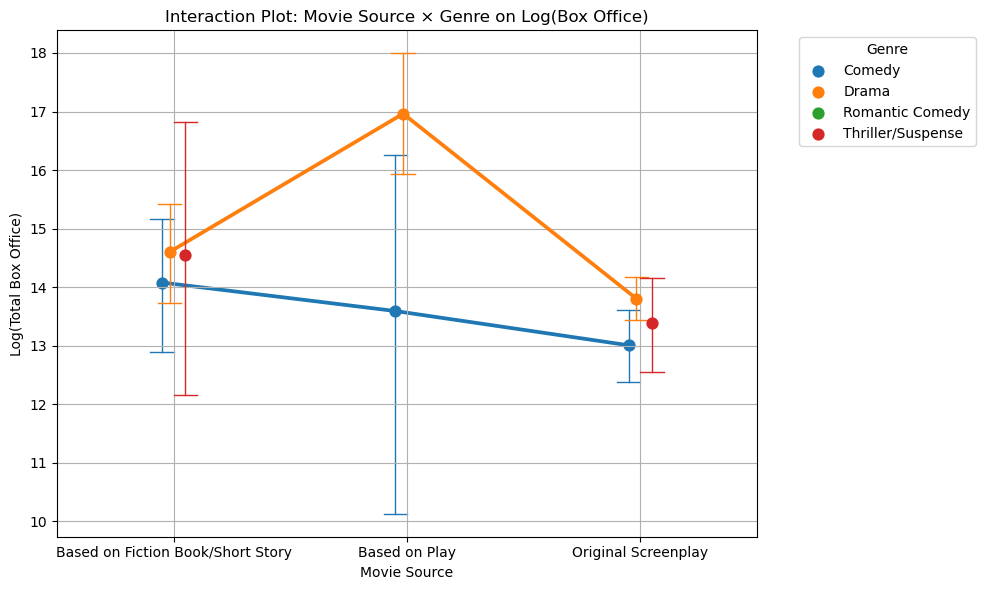

In [129]:
# Ensure budget_category and genre are categorical with proper order
subset_df['source'] = subset_df['source'].astype('category')
subset_df['genre'] = subset_df['genre'].astype('category')

# Interaction plot using seaborn lineplot (grouped by genre)
plt.figure(figsize=(10, 6))
sns.pointplot(
    data=subset_df,
    x='source',
    y='log_total_box_office',
    hue='genre',
    dodge=True,
    markers='o',
    capsize=.1,
    errwidth=1,
    palette='tab10'
)

plt.title('Interaction Plot: Movie Source × Genre on Log(Box Office)')
plt.ylabel('Log(Total Box Office)')
plt.xlabel('Movie Source')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, bartlett
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 1. 建議先確保 DataFrame 是獨立 copy，避免 SettingWithCopyWarning
df_anova = filtered_df.copy()

print(df_anova.shape)
df_anova.dropna(subset=['ranked_box_office','budget_category','source_binary'])
print(df_anova.shape)

# 2. 二因子 ANOVA 模型 (含交互作用)
model = ols('log_total_box_office ~ C(source_binary) * C(genre)', data=df_anova).fit()

# 3. 顯示 ANOVA Table (Type II)
anova_table = sm.stats.anova_lm(model, typ=2)
print("=== Two-way ANOVA ===")
print(anova_table)

# 4. 檢查殘差常態性：Shapiro–Wilk
shapiro_res = shapiro(model.resid)
print("\n=== Shapiro–Wilk Test on Residuals ===")
print(f"W = {shapiro_res.statistic:.4f}, p-value = {shapiro_res.pvalue:.4f}")
if shapiro_res.pvalue < 0.05:
    print("→ 殘差不符合常態分配 (p < 0.05)")
else:
    print("→ 殘差符合常態分配 (p ≥ 0.05)")

# 5. 檢查各組變異數齊性：Levene’s Test (對中位數穩健)
#    先把 8 組 (source_binary×genre) 的 residuals 抽出
groups = []
for src in df_anova['source_binary'].unique():
    for g in df_anova['genre'].unique():
        sub = df_anova[
            (df_anova['source_binary']==src) &
            (df_anova['genre']==g)
        ]['log_total_box_office'].dropna()
        groups.append(sub)

levene_stat, levene_p = levene(*groups, center='median')
print("\n=== Levene’s Test for Homogeneity ===")
print(f"Statistic = {levene_stat:.4f}, p-value = {levene_p:.4f}")
if levene_p < 0.05:
    print("→ 各組變異數不等 (p < 0.05)")
else:
    print("→ 各組變異數可視為相等 (p ≥ 0.05)")

# （可選）用 Bartlett’s Test 做對比
bart_stat, bart_p = bartlett(*groups)
print("\n=== Bartlett’s Test for Homogeneity (比較敏感) ===")
print(f"Statistic = {bart_stat:.4f}, p-value = {bart_p:.4f}")
if bart_p < 0.05:
    print("→ 各組變異數不等 (p < 0.05)")
else:
    print("→ 各組變異數可視為相等 (p ≥ 0.05)")


(458, 28)
(458, 28)
=== Two-way ANOVA ===
                                sum_sq     df         F    PR(>F)
C(source_binary)              7.688378    1.0  1.006312  0.316327
C(genre)                     59.097711    3.0  2.578382  0.053159
C(source_binary):C(genre)     7.083996    3.0  0.309069  0.818840
Residual                   3438.069920  450.0       NaN       NaN

=== Shapiro–Wilk Test on Residuals ===
W = 0.9668, p-value = 0.0000
→ 殘差不符合常態分配 (p < 0.05)

=== Levene’s Test for Homogeneity ===
Statistic = 1.7094, p-value = 0.1048
→ 各組變異數可視為相等 (p ≥ 0.05)

=== Bartlett’s Test for Homogeneity (比較敏感) ===
Statistic = 12.0007, p-value = 0.1005
→ 各組變異數可視為相等 (p ≥ 0.05)


In [131]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 先複製 DataFrame，並建立一個互動組別欄位
df_tukey = df_anova.copy()
df_tukey['src_gen'] = df_tukey['source_binary'].astype(str) + ' & ' + df_tukey['genre'].astype(str)

# 1. 對 source_binary 做 Tukey
tukey_src = pairwise_tukeyhsd(
    endog=df_tukey['log_total_box_office'],
    groups=df_tukey['source_binary'],
    alpha=0.05
)
print("Tukey HSD for Source:")
print(tukey_src.summary())

# 2. 對 genre 做 Tukey
tukey_genre = pairwise_tukeyhsd(
    endog=df_tukey['log_total_box_office'],
    groups=df_tukey['genre'],
    alpha=0.05
)
print("\nTukey HSD for Genre:")
print(tukey_genre.summary())

# 3. 對 interaction (source × genre) 做 Tukey
tukey_inter = pairwise_tukeyhsd(
    endog=df_tukey['log_total_box_office'],
    groups=df_tukey['src_gen'],
    alpha=0.05
)
print("\nTukey HSD for Source × Genre Interaction:")
print(tukey_inter.summary())


Tukey HSD for Source:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
 group1        group2       meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
Adapted Original Screenplay  -0.3891 0.2073 -0.9947 0.2164  False
-----------------------------------------------------------------

Tukey HSD for Genre:
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------
         Comedy             Drama   0.8588 0.0358  0.0393 1.6783   True
         Comedy   Romantic Comedy   0.0677 0.9995 -1.4886  1.624  False
         Comedy Thriller/Suspense   0.4418 0.7368 -0.6732 1.5568  False
          Drama   Romantic Comedy  -0.7911 0.5034 -2.2538 0.6716  False
          Drama Thriller/Suspense   -0.417 0.6916 -1.3971 0.5632  False
Romantic Comedy Thriller/Suspense   0.3741 0.9363 

In [132]:
model_full = ols(
    'log_total_box_office ~ C(budget_category) + C(source_binary) + C(genre)',
    data=df_anova
).fit()
print(sm.stats.anova_lm(model_full, typ=2))


                         sum_sq     df          F        PR(>F)
C(budget_category)   306.792738    1.0  45.387683  5.015498e-11
C(source_binary)       0.338944    1.0   0.050144  8.229152e-01
C(genre)              56.913178    3.0   2.806626  3.929593e-02
Residual            3007.925510  445.0        NaN           NaN


In [133]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 假設你已經有這個 DataFrame：
df_full = filtered_df.copy()

# 1. Budget Category Tukey
budget_df = df_full[['log_total_box_office', 'budget_category']].dropna()
budget_df['budget_category'] = budget_df['budget_category'].astype(str)
tukey_budget = pairwise_tukeyhsd(
    endog=budget_df['log_total_box_office'],
    groups=budget_df['budget_category'],
    alpha=0.05
)
print("Tukey HSD for Budget Category:")
print(tukey_budget.summary())

# 2. Source Binary Tukey
source_df = df_full[['log_total_box_office', 'source_binary']].dropna()
source_df['source_binary'] = source_df['source_binary'].astype(str)
tukey_source = pairwise_tukeyhsd(
    endog=source_df['log_total_box_office'],
    groups=source_df['source_binary'],
    alpha=0.05
)
print("\nTukey HSD for Source Binary:")
print(tukey_source.summary())

# 3. Genre Tukey
genre_df = df_full[['log_total_box_office', 'genre']].dropna()
genre_df['genre'] = genre_df['genre'].astype(str)
tukey_genre = pairwise_tukeyhsd(
    endog=genre_df['log_total_box_office'],
    groups=genre_df['genre'],
    alpha=0.05
)
print("\nTukey HSD for Genre:")
print(tukey_genre.summary())


Tukey HSD for Budget Category:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  High    Low   -1.685   0.0 -2.1688 -1.2013   True
---------------------------------------------------

Tukey HSD for Source Binary:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
 group1        group2       meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
Adapted Original Screenplay  -0.3891 0.2073 -0.9947 0.2164  False
-----------------------------------------------------------------

Tukey HSD for Genre:
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------
         Comedy             Drama   0.8588 0.0358  0.0393 1.6783   True
         Comedy   Romantic Comedy   0.0

# Kruskal Wallis

## Romantic Comedy

In [134]:
import numpy as np
from scipy.stats import kruskal, levene, shapiro, bartlett

# 1. 篩出 Romantic Comedy 且沒有缺失的資料
df_rom = filtered_df.dropna(subset=['genre','source_binary','log_total_box_office'])
df_rom = df_rom[df_rom['genre']=='Romantic Comedy']

# 2. 分成 Adapted / Original 兩組
adapted_vals  = df_rom.loc[df_rom['source_binary']=='Adapted',  'log_total_box_office']
original_vals = df_rom.loc[df_rom['source_binary']=='Original Screenplay', 'log_total_box_office']

# 3. Shapiro–Wilk 常態性檢定
sw_a_stat, sw_a_p = shapiro(adapted_vals)
sw_o_stat, sw_o_p = shapiro(original_vals)
print("=== Shapiro–Wilk Test ===")
print(f"Adapted:  W = {sw_a_stat:.4f}, p = {sw_a_p:.4f}")
print(f"Original: W = {sw_o_stat:.4f}, p = {sw_o_p:.4f}")
if sw_a_p < 0.05 or sw_o_p < 0.05:
    print("→ 至少一組違反常態性 (p < 0.05)\n")
else:
    print("→ 兩組皆符合常態性 (p ≥ 0.05)\n")

# 4. Levene’s Test for Homogeneity
stat_lv, p_lv = levene(adapted_vals, original_vals, center='median')
print("=== Levene’s Test for Homogeneity ===")
print(f"Statistic = {stat_lv:.4f}, p = {p_lv:.4f}")
if p_lv < 0.05:
    print("→ 各組變異數不齊 (p < 0.05)\n")
else:
    print("→ 各組變異數可視為齊性 (p ≥ 0.05)\n")

# 5. Bartlett’s Test for Homogeneity
stat_bt, p_bt = bartlett(adapted_vals, original_vals)
print("=== Bartlett’s Test for Homogeneity ===")
print(f"Statistic = {stat_bt:.4f}, p = {p_bt:.4f}")
if p_bt < 0.05:
    print("→ 各組變異數不齊 (p < 0.05)\n")
else:
    print("→ 各組變異數可視為齊性 (p ≥ 0.05)\n")

# 6. Kruskal–Wallis 檢定
H, p_kw = kruskal(adapted_vals, original_vals)
print(f"Kruskal–Wallis H = {H:.4f}, p = {p_kw:.4f}")


# 8. 各組中位數與平均秩次
medians = df_rom.groupby('source_binary')['log_total_box_office'].median()
mean_ranks = df_rom.assign(rank=df_rom['log_total_box_office'].rank()) \
                   .groupby('source_binary')['rank'].mean()
print("\n各組中位數：")
print(medians)
print("\n各組平均秩次：")
print(mean_ranks)


=== Shapiro–Wilk Test ===
Adapted:  W = 0.9509, p = 0.5731
Original: W = 0.9218, p = 0.0727
→ 兩組皆符合常態性 (p ≥ 0.05)

=== Levene’s Test for Homogeneity ===
Statistic = 2.3333, p = 0.1397
→ 各組變異數可視為齊性 (p ≥ 0.05)

=== Bartlett’s Test for Homogeneity ===
Statistic = 0.9055, p = 0.3413
→ 各組變異數可視為齊性 (p ≥ 0.05)

Kruskal–Wallis H = 0.4654, p = 0.4951

各組中位數：
source_binary
Adapted                15.016701
Original Screenplay    13.674041
Name: log_total_box_office, dtype: float64

各組平均秩次：
source_binary
Adapted                16.333333
Original Screenplay    13.130435
Name: rank, dtype: float64


## Comedy

In [146]:
import numpy as np
from scipy.stats import kruskal, levene, shapiro, bartlett

# 1. 篩出 Romantic Comedy 且沒有缺失的資料
df_rom = filtered_df.dropna(subset=['genre','source_binary','log_total_box_office'])
df_rom = df_rom[df_rom['genre']=='Comedy']

# 2. 分成 Adapted / Original 兩組
adapted_vals  = df_rom.loc[df_rom['source_binary']=='Adapted',  'log_total_box_office']
original_vals = df_rom.loc[df_rom['source_binary']=='Original Screenplay', 'log_total_box_office']

# 3. Shapiro–Wilk 常態性檢定
sw_a_stat, sw_a_p = shapiro(adapted_vals)
sw_o_stat, sw_o_p = shapiro(original_vals)
print("=== Shapiro–Wilk Test ===")
print(f"Adapted:  W = {sw_a_stat:.4f}, p = {sw_a_p:.4f}")
print(f"Original: W = {sw_o_stat:.4f}, p = {sw_o_p:.4f}")
if sw_a_p < 0.05 or sw_o_p < 0.05:
    print("→ 至少一組違反常態性 (p < 0.05)\n")
else:
    print("→ 兩組皆符合常態性 (p ≥ 0.05)\n")

# 4. Levene’s Test for Homogeneity
stat_lv, p_lv = levene(adapted_vals, original_vals, center='median')
print("=== Levene’s Test for Homogeneity ===")
print(f"Statistic = {stat_lv:.4f}, p = {p_lv:.4f}")
if p_lv < 0.05:
    print("→ 各組變異數不齊 (p < 0.05)\n")
else:
    print("→ 各組變異數可視為齊性 (p ≥ 0.05)\n")

# 5. Bartlett’s Test for Homogeneity
stat_bt, p_bt = bartlett(adapted_vals, original_vals)
print("=== Bartlett’s Test for Homogeneity ===")
print(f"Statistic = {stat_bt:.4f}, p = {p_bt:.4f}")
if p_bt < 0.05:
    print("→ 各組變異數不齊 (p < 0.05)\n")
else:
    print("→ 各組變異數可視為齊性 (p ≥ 0.05)\n")

# 6. Kruskal–Wallis 檢定
H, p_kw = kruskal(adapted_vals, original_vals)
print(f"Kruskal–Wallis H = {H:.4f}, p = {p_kw:.4f}")


# 8. 各組中位數與平均秩次
medians = df_rom.groupby('source_binary')['log_total_box_office'].median()
mean_ranks = df_rom.assign(rank=df_rom['log_total_box_office'].rank()) \
                   .groupby('source_binary')['rank'].mean()
print("\n各組中位數：")
print(medians)
print("\n各組平均秩次：")
print(mean_ranks)


=== Shapiro–Wilk Test ===
Adapted:  W = 0.9406, p = 0.1849
Original: W = 0.9533, p = 0.0043
→ 至少一組違反常態性 (p < 0.05)

=== Levene’s Test for Homogeneity ===
Statistic = 0.0037, p = 0.9514
→ 各組變異數可視為齊性 (p ≥ 0.05)

=== Bartlett’s Test for Homogeneity ===
Statistic = 0.0709, p = 0.7900
→ 各組變異數可視為齊性 (p ≥ 0.05)

Kruskal–Wallis H = 0.0324, p = 0.8571

各組中位數：
source_binary
Adapted                13.610535
Original Screenplay    13.364065
Name: log_total_box_office, dtype: float64

各組平均秩次：
source_binary
Adapted                54.521739
Original Screenplay    53.216867
Name: rank, dtype: float64


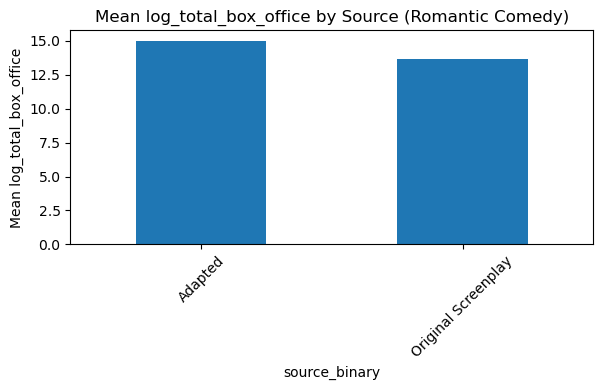

In [150]:
import matplotlib.pyplot as plt

# 1. 篩選 Romantic Comedy
df_rom = filtered_df[
    (filtered_df['genre'] == 'Romantic Comedy') &
    filtered_df['log_total_box_office'].notna() &
    filtered_df['source_binary'].notna()
].copy()

# 2. 計算各組平均值
means = df_rom.groupby('source_binary')['log_total_box_office'].median()

# 3. 繪製長條圖
plt.figure(figsize=(6, 4))
means.plot(kind='bar')
plt.ylabel('Mean log_total_box_office')
plt.title('Mean log_total_box_office by Source (Romantic Comedy)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Drama

In [148]:
import numpy as np
from scipy.stats import kruskal, levene, shapiro, bartlett

# 1. 篩出 Romantic Comedy 且沒有缺失的資料
df_rom = filtered_df.dropna(subset=['genre','source_binary','log_total_box_office'])
df_rom = df_rom[df_rom['genre']=='Drama']

# 2. 分成 Adapted / Original 兩組
adapted_vals  = df_rom.loc[df_rom['source_binary']=='Adapted',  'log_total_box_office']
original_vals = df_rom.loc[df_rom['source_binary']=='Original Screenplay', 'log_total_box_office']

# 3. Shapiro–Wilk 常態性檢定
sw_a_stat, sw_a_p = shapiro(adapted_vals)
sw_o_stat, sw_o_p = shapiro(original_vals)
print("=== Shapiro–Wilk Test ===")
print(f"Adapted:  W = {sw_a_stat:.4f}, p = {sw_a_p:.4f}")
print(f"Original: W = {sw_o_stat:.4f}, p = {sw_o_p:.4f}")
if sw_a_p < 0.05 or sw_o_p < 0.05:
    print("→ 至少一組違反常態性 (p < 0.05)\n")
else:
    print("→ 兩組皆符合常態性 (p ≥ 0.05)\n")

# 4. Levene’s Test for Homogeneity
stat_lv, p_lv = levene(adapted_vals, original_vals, center='median')
print("=== Levene’s Test for Homogeneity ===")
print(f"Statistic = {stat_lv:.4f}, p = {p_lv:.4f}")
if p_lv < 0.05:
    print("→ 各組變異數不齊 (p < 0.05)\n")
else:
    print("→ 各組變異數可視為齊性 (p ≥ 0.05)\n")

# 5. Bartlett’s Test for Homogeneity
stat_bt, p_bt = bartlett(adapted_vals, original_vals)
print("=== Bartlett’s Test for Homogeneity ===")
print(f"Statistic = {stat_bt:.4f}, p = {p_bt:.4f}")
if p_bt < 0.05:
    print("→ 各組變異數不齊 (p < 0.05)\n")
else:
    print("→ 各組變異數可視為齊性 (p ≥ 0.05)\n")

# 6. Kruskal–Wallis 檢定
H, p_kw = kruskal(adapted_vals, original_vals)
print(f"Kruskal–Wallis H = {H:.4f}, p = {p_kw:.4f}")

# 7. 效果量 r
N = adapted_vals.size + original_vals.size
r = np.sqrt(H / (N - 1))
print(f"效果量 r = {r:.3f}")

# 8. 各組中位數與平均秩次
medians = df_rom.groupby('source_binary')['log_total_box_office'].median()
mean_ranks = df_rom.assign(rank=df_rom['log_total_box_office'].rank()) \
                   .groupby('source_binary')['rank'].mean()
print("\n各組中位數：")
print(medians)
print("\n各組平均秩次：")
print(mean_ranks)



=== Shapiro–Wilk Test ===
Adapted:  W = 0.9717, p = 0.1042
Original: W = 0.9572, p = 0.0000
→ 至少一組違反常態性 (p < 0.05)

=== Levene’s Test for Homogeneity ===
Statistic = 1.2479, p = 0.2650
→ 各組變異數可視為齊性 (p ≥ 0.05)

=== Bartlett’s Test for Homogeneity ===
Statistic = 2.7201, p = 0.0991
→ 各組變異數可視為齊性 (p ≥ 0.05)

Kruskal–Wallis H = 0.1924, p = 0.6609
效果量 r = 0.027

各組中位數：
source_binary
Adapted                14.532237
Original Screenplay    14.139762
Name: log_total_box_office, dtype: float64

各組平均秩次：
source_binary
Adapted                133.805556
Original Screenplay    129.234043
Name: rank, dtype: float64


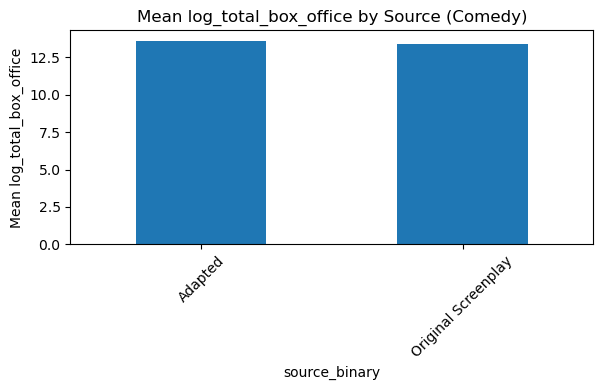

In [151]:
import matplotlib.pyplot as plt

# 1. 篩選 Romantic Comedy
df_rom = filtered_df[
    (filtered_df['genre'] == 'Comedy') &
    filtered_df['log_total_box_office'].notna() &
    filtered_df['source_binary'].notna()
].copy()

# 2. 計算各組平均值
means = df_rom.groupby('source_binary')['log_total_box_office'].median()

# 3. 繪製長條圖
plt.figure(figsize=(6, 4))
means.plot(kind='bar')
plt.ylabel('Mean log_total_box_office')
plt.title('Mean log_total_box_office by Source (Comedy)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Thriller/Suspense

In [153]:
import numpy as np
from scipy.stats import kruskal, levene, shapiro, bartlett

# 1. 篩出 Romantic Comedy 且沒有缺失的資料
df_rom = filtered_df.dropna(subset=['genre','source_binary','log_total_box_office'])
df_rom = df_rom[df_rom['genre']=='Thriller/Suspense']

print(df_rom.shape)
# 2. 分成 Adapted / Original 兩組
adapted_vals  = df_rom.loc[df_rom['source_binary']=='Adapted',  'log_total_box_office']
original_vals = df_rom.loc[df_rom['source_binary']=='Original Screenplay', 'log_total_box_office']

# 3. Shapiro–Wilk 常態性檢定
sw_a_stat, sw_a_p = shapiro(adapted_vals)
sw_o_stat, sw_o_p = shapiro(original_vals)
print("=== Shapiro–Wilk Test ===")
print(f"Adapted:  W = {sw_a_stat:.4f}, p = {sw_a_p:.4f}")
print(f"Original: W = {sw_o_stat:.4f}, p = {sw_o_p:.4f}")
if sw_a_p < 0.05 or sw_o_p < 0.05:
    print("→ 至少一組違反常態性 (p < 0.05)\n")
else:
    print("→ 兩組皆符合常態性 (p ≥ 0.05)\n")

# 4. Levene’s Test for Homogeneity
stat_lv, p_lv = levene(adapted_vals, original_vals, center='median')
print("=== Levene’s Test for Homogeneity ===")
print(f"Statistic = {stat_lv:.4f}, p = {p_lv:.4f}")
if p_lv < 0.05:
    print("→ 各組變異數不齊 (p < 0.05)\n")
else:
    print("→ 各組變異數可視為齊性 (p ≥ 0.05)\n")

# 5. Bartlett’s Test for Homogeneity
stat_bt, p_bt = bartlett(adapted_vals, original_vals)
print("=== Bartlett’s Test for Homogeneity ===")
print(f"Statistic = {stat_bt:.4f}, p = {p_bt:.4f}")
if p_bt < 0.05:
    print("→ 各組變異數不齊 (p < 0.05)\n")
else:
    print("→ 各組變異數可視為齊性 (p ≥ 0.05)\n")

# 6. Kruskal–Wallis 檢定
H, p_kw = kruskal(adapted_vals, original_vals)
print(f"Kruskal–Wallis H = {H:.4f}, p = {p_kw:.4f}")

# 7. 效果量 r
N = adapted_vals.size + original_vals.size
r = np.sqrt(H / (N - 1))
print(f"效果量 r = {r:.3f}")

# 8. 各組中位數與平均秩次
medians = df_rom.groupby('source_binary')['log_total_box_office'].median()
mean_ranks = df_rom.assign(rank=df_rom['log_total_box_office'].rank()) \
                   .groupby('source_binary')['rank'].mean()
print("\n各組中位數：")
print(medians)
print("\n各組平均秩次：")
print(mean_ranks)


(66, 28)
=== Shapiro–Wilk Test ===
Adapted:  W = 0.8781, p = 0.2181
Original: W = 0.9237, p = 0.0012
→ 至少一組違反常態性 (p < 0.05)

=== Levene’s Test for Homogeneity ===
Statistic = 0.0074, p = 0.9315
→ 各組變異數可視為齊性 (p ≥ 0.05)

=== Bartlett’s Test for Homogeneity ===
Statistic = 0.0013, p = 0.9708
→ 各組變異數可視為齊性 (p ≥ 0.05)

Kruskal–Wallis H = 0.4303, p = 0.5118
效果量 r = 0.081

各組中位數：
source_binary
Adapted                15.257292
Original Screenplay    13.655585
Name: log_total_box_office, dtype: float64

各組平均秩次：
source_binary
Adapted                38.000000
Original Screenplay    32.966102
Name: rank, dtype: float64


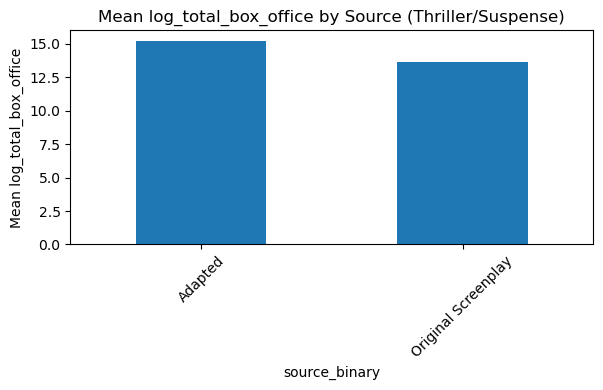

In [152]:
import matplotlib.pyplot as plt

# 1. 篩選 Romantic Comedy
df_rom = filtered_df[
    (filtered_df['genre'] == 'Thriller/Suspense') &
    filtered_df['log_total_box_office'].notna() &
    filtered_df['source_binary'].notna()
].copy()

# 2. 計算各組平均值
means = df_rom.groupby('source_binary')['log_total_box_office'].median()

# 3. 繪製長條圖
plt.figure(figsize=(6, 4))
means.plot(kind='bar')
plt.ylabel('Mean log_total_box_office')
plt.title('Mean log_total_box_office by Source (Thriller/Suspense)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
